In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Harmful Algae Blooms in Bolinao (from HABhub) - Sheet1.csv")
print(df.shape)
print(df.info())
df.head()

(1929, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station_name      1929 non-null   object 
 1   embayment         1929 non-null   object 
 2   longitude         1929 non-null   float64
 3   latitude          1929 non-null   float64
 4   sample_date       1929 non-null   object 
 5   dissolved oxygen  1929 non-null   float64
 6   ph                1929 non-null   float64
 7   water temp        1929 non-null   float64
 8   time              1929 non-null   object 
 9   chlorophyll-a     1929 non-null   float64
dtypes: float64(6), object(4)
memory usage: 150.8+ KB
None


,station_name,embayment,longitude,latitude,sample_date,dissolved oxygen,ph,water temp,time,chlorophyll-a
0,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.5200,7.5755,28.8045,0:01:00,2.6136
1,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.0384,7.5566,28.7676,1:01:00,2.4442
2,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
3,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.1008,7.5566,28.7575,3:01:00,2.2264
4,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9424,7.6007,28.8213,4:01:00,2.4079


### Split
Let us split the data first to prevent any leakage

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
df_train.nunique()

station_name           1
embayment              1
longitude              1
latitude               1
sample_date           92
dissolved oxygen     868
ph                   244
water temp          1480
time                  24
chlorophyll-a        689
dtype: int64

In [5]:
cont_vars = df_train.nunique() != 1
filtered_df = df_train[df_train.columns[cont_vars]]
filtered_df = filtered_df.rename(columns={"chlorophyll-a": "chl", 
                                         "dissolved oxygen": "dissolved_oxygen",
                                         "water temp": "water_temp"})
filtered_df

,sample_date,dissolved_oxygen,ph,water_temp,time,chl
1352,2022-10-12,-2.6848,6.9140,30.6774,6:01:00,4.6948
141,2022-08-17,0.3344,7.5692,29.8578,2:01:00,3.4848
2,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
1190,2022-10-01,-0.7552,6.8762,30.2540,10:01:00,2.9645
1803,2023-10-02,1.1163,-0.2700,32.4355,15:01:00,1.6214
...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,22:01:00,2.9282
1294,2022-10-07,0.2960,6.8825,31.8933,19:01:00,7.3689
860,2022-09-17,-1.2544,6.8069,30.6729,13:01:00,4.5980
1459,2022-10-18,-2.6992,6.7754,29.7998,0:01:00,1.6335


In [6]:
filtered_df['sample_date'] = pd.to_datetime(filtered_df["sample_date"])
filtered_df['sample_date_int'] = filtered_df['sample_date'].astype("int64") / 10**11

filtered_df['time_hour'] = pd.to_datetime(filtered_df['time'], format="%H:%M:%S").dt.hour
filtered_df.drop(columns="time", inplace=True)

##### Note

* Converted `sample_date` to datetime format
* Added `sample_date_int` as a int varsion of the `sample_date` column
* Added `time_hour` to get only the Hour in time
* Removed the `time` column

Let us first do a simple Multiple Linear Regression to get a glimpse of everything

In [7]:
from statsmodels.formula.api import ols

formula = "chl ~ " + " + ".join([col for col in filtered_df.drop(columns="sample_date").columns  if col != "chl"])
lmlm = ols(formula, data=filtered_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     103.2
Date:                Thu, 01 May 2025   Prob (F-statistic):           5.07e-94
Time:                        19:34:38   Log-Likelihood:                -4385.5
No. Observations:                1543   AIC:                             8783.
Df Residuals:                    1537   BIC:                             8815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          718.6260     94.972      7.567      0.000     532.337     904.915
dissolved_oxygen     0.0799      0.036      2.226      0.026       0.009       0.150
ph                  -1.4007      0.278     -5.047      0.000      -1.945      -0.856
water_temp           1.9163      0.106     18.070      0.000       1.708       2.124
sample_date_int  -4.583e-05    5.6e-06     -8.184      0.000   -5.68e-05   -3.48e-05
time_hour            0.0729      0.016      4.573      0.000       0.042       0.104
==============================================================================
Omnibus:                     1067.235   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17136.045
Skew:                           3.060   Prob(JB):                         0.00
Kurtosis:                      18.135   Cond. No.                     1.49e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All are significant except the `dissolved_oxygen` which could be problematic given that we need that column!

In [8]:
filtered_df

,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour
1352,2022-10-12,-2.6848,6.9140,30.6774,4.6948,16655328.0,6
141,2022-08-17,0.3344,7.5692,29.8578,3.4848,16606944.0,2
2,2022-08-11,-0.9472,7.5881,28.7926,2.6257,16601760.0,2
1190,2022-10-01,-0.7552,6.8762,30.2540,2.9645,16645824.0,10
1803,2023-10-02,1.1163,-0.2700,32.4355,1.6214,16962048.0,15
...,...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,2.9282,16643232.0,22
1294,2022-10-07,0.2960,6.8825,31.8933,7.3689,16651008.0,19
860,2022-09-17,-1.2544,6.8069,30.6729,4.5980,16633728.0,13
1459,2022-10-18,-2.6992,6.7754,29.7998,1.6335,16660512.0,0


## EDA

#### Missing Values

In [9]:
filtered_df.isna().sum()

sample_date         0
dissolved_oxygen    0
ph                  0
water_temp          0
chl                 0
sample_date_int     0
time_hour           0
dtype: int64

#### Distribution

Text(0.5, 1.0, 'Distribution of Columns')

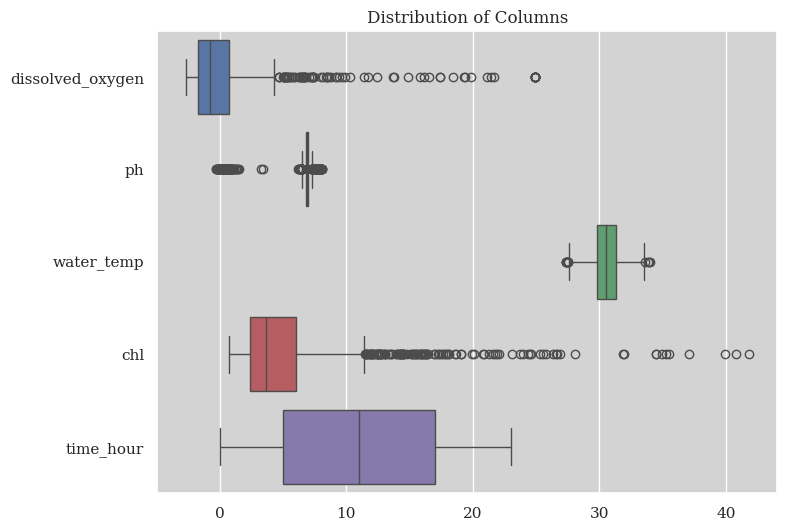

In [10]:
plt.figure(figsize=(8, 6))

sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['font.family'] = 'serif'

sns.boxplot(filtered_df.drop(columns=["sample_date", 'sample_date_int']), orient="h")
plt.title("Distribution of Columns")

Lots of outliers in all of columns with exception of `time_hour`

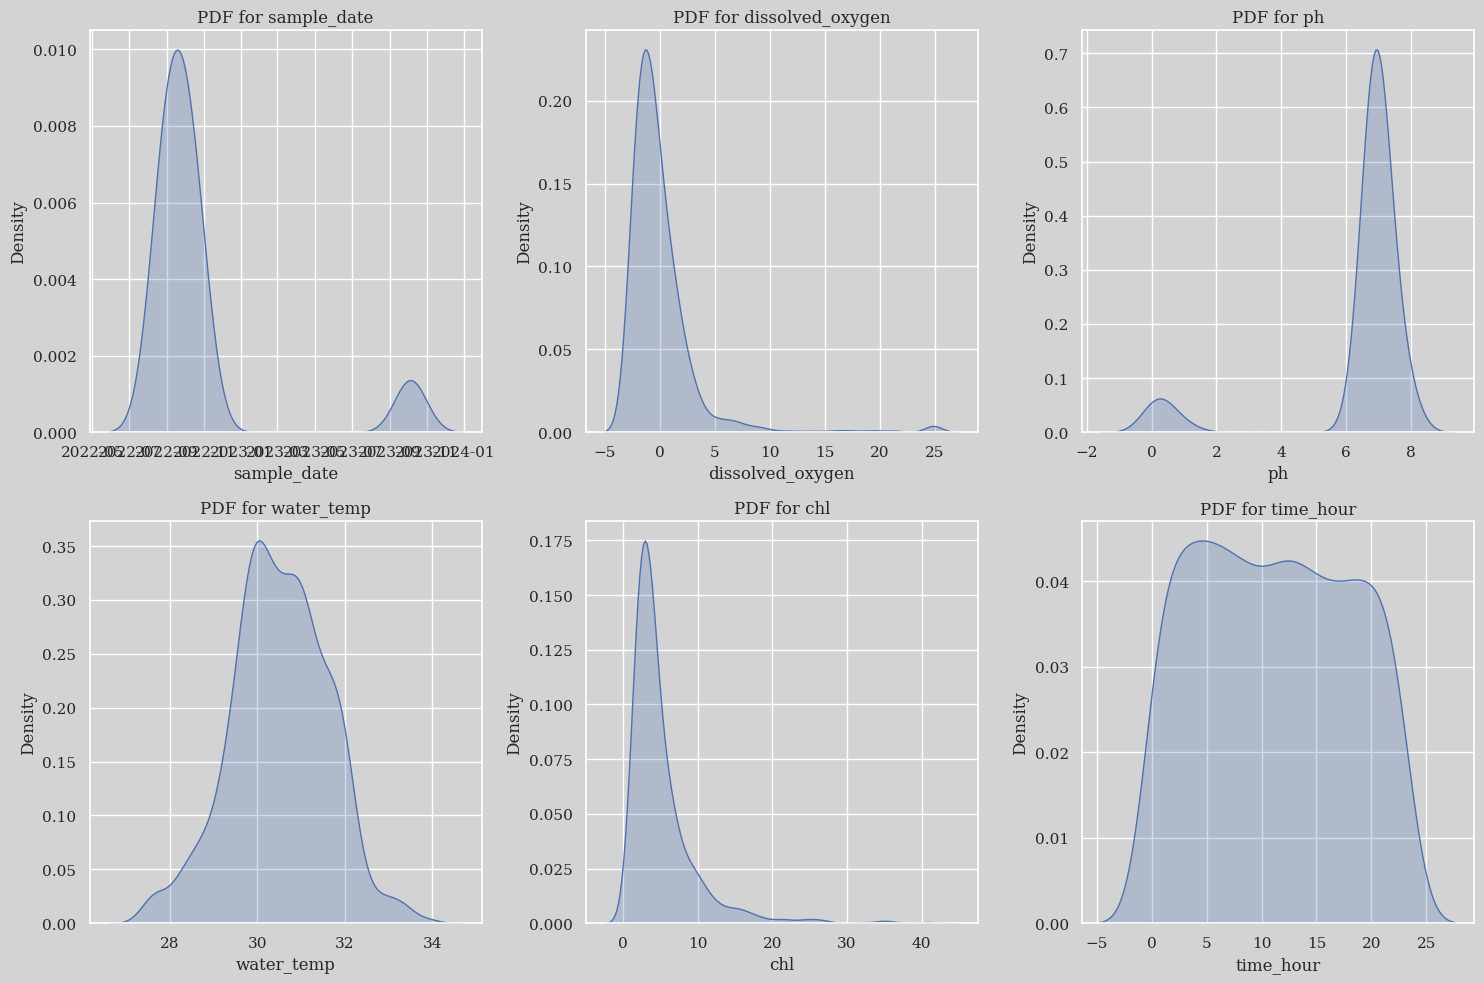

In [11]:

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

axes = ax.flatten()
cols = filtered_df.drop(columns=['sample_date_int']).columns.to_list()

for ind,col in enumerate(cols):
    sns.kdeplot(filtered_df[col], fill=True, ax=axes[ind])
    axes[ind].set_title(f"PDF for {col}")

plt.tight_layout()

Well it appears that all of our columns are skewed! With the exceptions of `water_temp` and `time_hour`.

This isn't usually an issue in a linear regression model but given that we also got significant amount of outliers for each of those skewed data, a transformation is in order. With transformation, we can reduce the outliers and normalize the data which is beneficial for our linear model.

Let's look at the range before proceeding.

In [12]:
filtered_df.aggregate(["min", "max"])

,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour
min,2022-08-11,-2.6992,-0.2700,27.3432,0.7018,16601760.0,0
max,2023-10-16,24.8880,8.0606,33.9583,41.8297,16974144.0,23


So we can't do log transformation because `dissolved_oxygen` and `ph` has negative values.

Let's try "Yeo-Jhonson" since it can handle negative values.

In [13]:
filtered_df_fix = filtered_df.drop(columns=['sample_date_int', 'sample_date'])

In [14]:
from sklearn.preprocessing import PowerTransformer
cols = filtered_df_fix.columns.to_list()

pt = PowerTransformer(method="yeo-johnson")

pt.fit(filtered_df_fix)

new_data = pt.transform(filtered_df_fix)

new_df = pd.DataFrame(new_data, columns=cols)

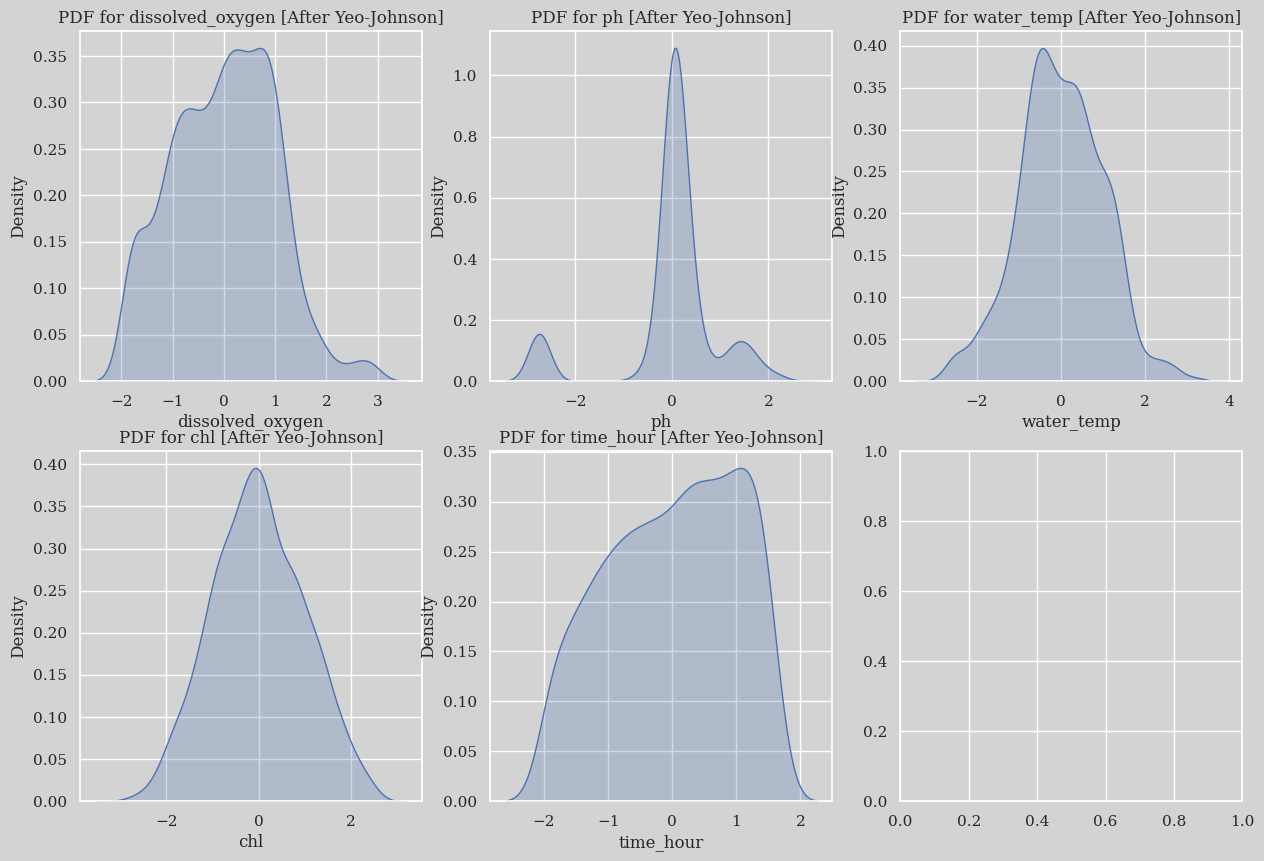

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

axes = ax.flatten()
cols = new_df.columns.to_list()

for ind,col in enumerate(cols):
    sns.kdeplot(new_df[col], fill=True, ax=axes[ind])
    axes[ind].set_title(f"PDF for {col} [After Yeo-Johnson]")

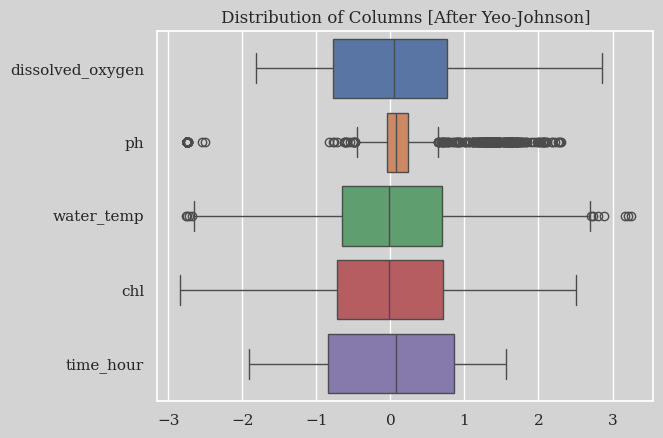

In [16]:
sns.boxplot(new_df, orient="h")
plt.title("Distribution of Columns [After Yeo-Johnson]");

There we go! Not only Yeo-Johnson makes the distribution Normal but it also lessen the outliers! 

But there's still some work to do for there are still outliers.

Our focus now shall be the `water_temp` and `ph`.

And how to mitigate them effects.

In [17]:
def detect_outliers(data, mult=1.5, normalized=True):
    '''Count the outliers using iqr'''
    lower, upper = data.quantile([0.25,0.75])

    iqr = upper - lower

    lower_bound, upper_bound = lower - iqr*mult, upper + iqr*mult

    outliers = len(data) - (data.between(lower_bound, upper_bound)).sum()
    if not normalized:
        return outliers
    else:
        return outliers / len(data)

In [18]:
new_df.apply(detect_outliers, axis=0) 

dissolved_oxygen    0.000000
ph                  0.235904
water_temp          0.007129
chl                 0.000000
time_hour           0.000000
dtype: float64

#### Correlation

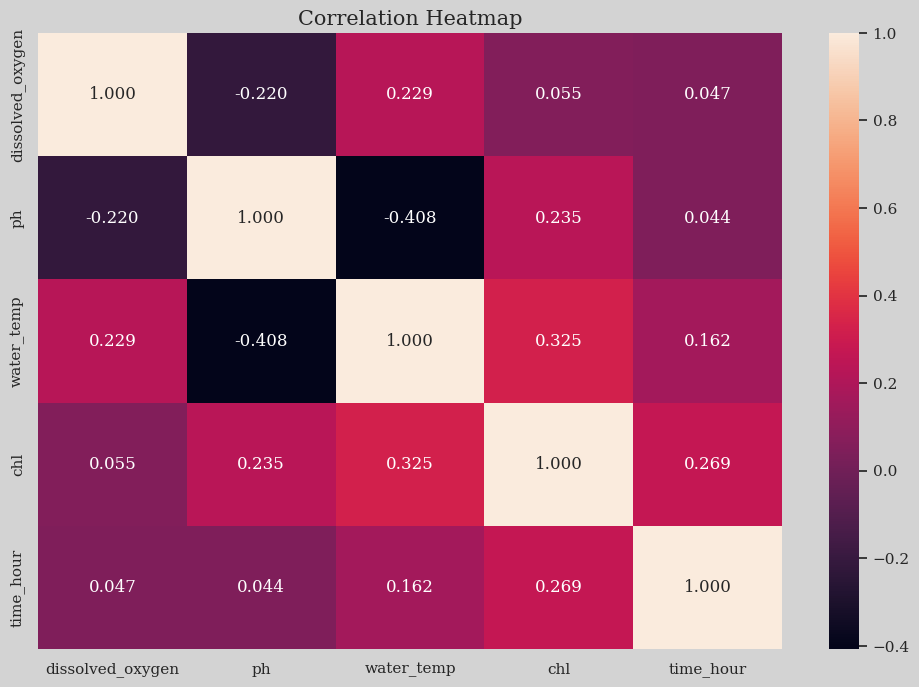

In [19]:

corr = new_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".3f"
)

plt.title("Correlation Heatmap", size=15);

#### Patterns

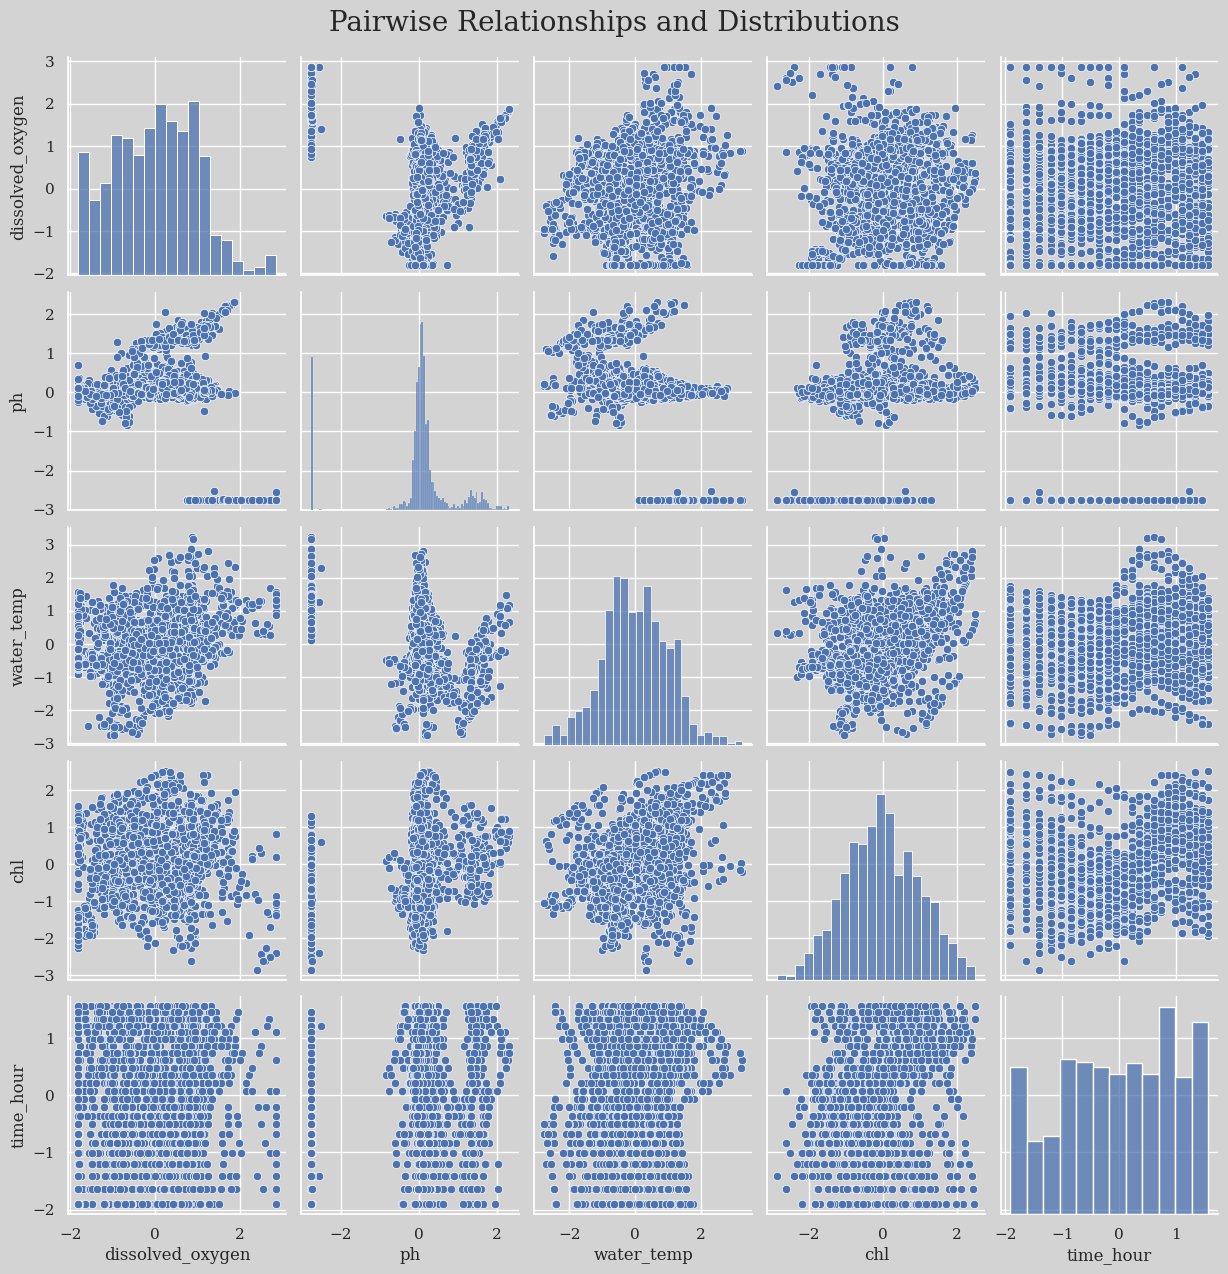

In [20]:
g = sns.pairplot(new_df)


g.figure.suptitle("Pairwise Relationships and Distributions", y=1.02, size=20)

plt.show();


If we look at the column of `ph`, it appears that there's a large gap between the  outliers and the mean. This could be an error in measurement(?)

In [21]:
samp = new_df['ph'].value_counts(normalize=True).reset_index()
samp[samp['ph'] < -2].sum()['proportion']

0.09008425145819834

9% are -2 or below!

In [22]:
samp = pd.concat([new_df, filtered_df['sample_date_int']],axis=1)

In [23]:
formula = "chl ~ " + " + ".join([col for col in samp.columns  if col != "chl"])
lmlm = ols(formula, data=samp)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     104.3
Date:                Thu, 01 May 2025   Prob (F-statistic):           6.27e-92
Time:                        19:34:55   Log-Likelihood:                -1545.6
No. Observations:                1244   AIC:                             3103.
Df Residuals:                    1238   BIC:                             3134.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.2799     22.531      0.323      0.747     -36.922      51.482
dissolved_oxygen     0.0200      0.025      0.803      0.422      -0.029       0.069
ph                   0.4201      0.027     15.758      0.000       0.368       0.472
water_temp           0.4572      0.027     16.881      0.000       0.404       0.510
time_hour            0.1889      0.024      7.793      0.000       0.141       0.236
sample_date_int  -4.367e-07   1.35e-06     -0.322      0.747   -3.09e-06    2.22e-06
==============================================================================
Omnibus:                       14.539   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.883
Skew:                           0.076   Prob(JB):                      0.00715
Kurtosis:                       2.591   Cond. No.                     1.57e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So it appears that `ph`, `water_temp`, and `time_hour` are good indicator based on their p-values. On the other hand, `sample_date_int` and `dissolved_oxygen` aren't significant indicator.

Adj R-Sq square improved by about 4% compared to the original dataset but I don't think that's enough.

But the most noticable improvement is in BIC and AIC that was reduced by about 5000! BIC and AIC should be lower so that's a good sign.

In [24]:
formula = "chl ~ " + " + ".join([col for col in samp.drop(columns=['sample_date_int', 'dissolved_oxygen']).columns  if col != "chl"])
lmlm = ols(formula, data=samp)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     217.0
Date:                Thu, 01 May 2025   Prob (F-statistic):          2.31e-117
Time:                        19:34:55   Log-Likelihood:                -1917.3
No. Observations:                1543   AIC:                             3843.
Df Residuals:                    1539   BIC:                             3864.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.674e-17      0.021  -4.06e-15      1.000      -0.042       0.042
ph             0.4179      0.024     17.723      0.000       0.372       0.464
water_temp     0.4670      0.024     19.563      0.000       0.420       0.514
time_hour      0.1753      0.022      8.034      0.000       0.132       0.218
==============================================================================
Omnibus:                       18.068   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.242
Skew:                           0.078   Prob(JB):                      0.00220
Kurtosis:                       2.593   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using only the three significant columns increases the R-Squeared by 0.003 but does worsen the BIC and AIC by large amount so that's not good.

Note for next session:
* Should I revert the transformation on dependent (`chl`) for scale purposes when eveluating the df_test
* What to do with outliers.
* Feature engineering
* Consider binning the `ph` to flag outliers.
* Consider also using regularization (although this might not be needed given the small coefs)

---

## Feature Engineering

**Future Romand Here**: This is useless section. You can skip ahead

In [25]:
new_df

,dissolved_oxygen,ph,water_temp,chl,time_hour
0,-1.794564,0.104626,0.137189,0.354699,-0.670928
1,0.638491,1.245186,-0.598758,-0.112043,-1.410903
2,-0.078968,1.282553,-1.530630,-0.586223,-1.410903
3,0.060495,0.047437,-0.245048,-0.379805,-0.060585
4,0.882023,-2.752801,1.771080,-1.433355,0.610507
...,...,...,...,...,...
1538,-0.397576,0.221673,-0.775673,-0.400565,1.447552
1539,0.624037,0.056907,1.259177,0.982158,1.100301
1540,-0.323950,-0.055136,0.133104,0.323330,0.351336
1541,-1.811986,-0.100801,-0.650216,-1.420166,-1.907685


In [26]:
date_time = df[['sample_date', 'time']].copy()
date_time['sample_date_dt'] = pd.to_datetime(date_time['sample_date'], errors='coerce')

date_time['time_td'] = pd.to_timedelta(date_time['time'], errors='coerce')
date_time['combined_datetime'] = date_time['sample_date_dt'] + date_time['time_td']

new_df['datetime'] = date_time.combined_datetime



In [27]:
new_df.sort_values(by="datetime", inplace=True)

In [28]:
date_chl = new_df[['datetime', 'chl']].set_index("datetime")
new_df_copy = new_df.copy()
for n in range(1,11):
    new_df_copy[f'ma_{n}'] = new_df_copy['chl'].shift(1).rolling(window=n).mean()
new_df_copy.dropna(inplace=True)

<Axes: >

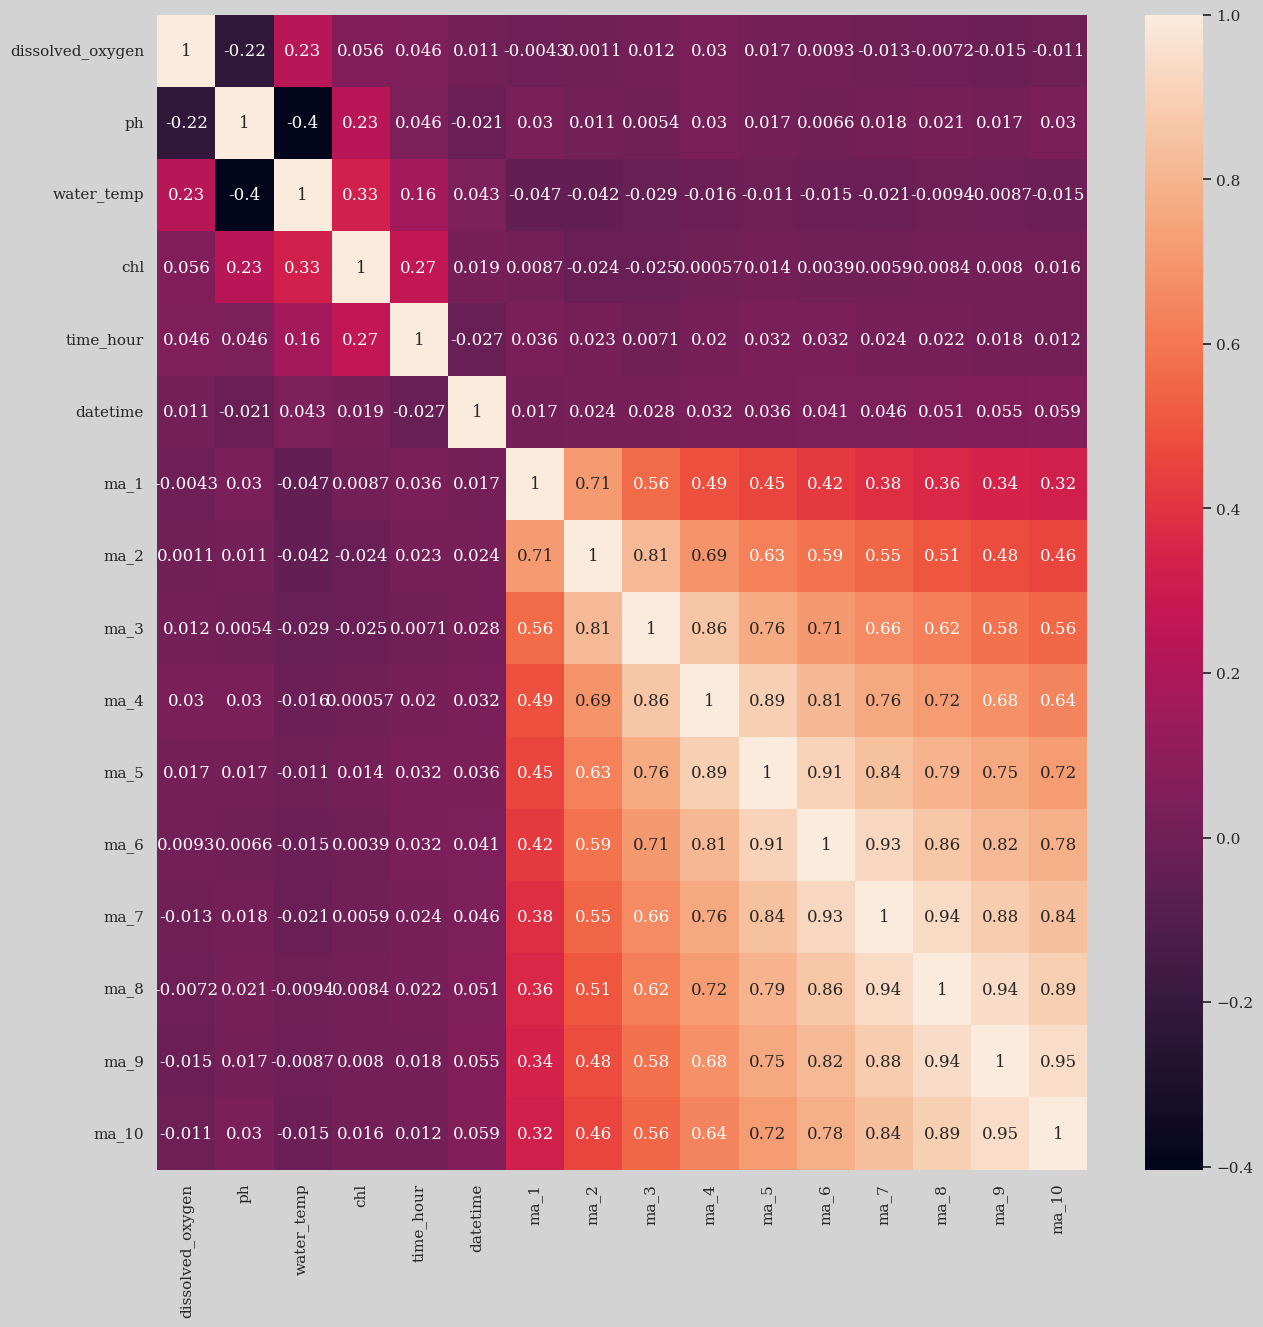

In [29]:
plt.figure(figsize=(15,15))
sns.heatmap(new_df_copy.corr(), annot=True)

In [30]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
X = new_df_copy.drop(columns=["chl", 'datetime'])
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.245960
time_hour           0.229512
ph                  0.180154
dissolved_oxygen    0.139627
ma_1                0.030416
ma_3                0.022303
ma_4                0.022080
ma_2                0.021354
ma_10               0.021198
ma_9                0.019303
ma_8                0.019101
ma_6                0.017798
ma_5                0.017052
ma_7                0.014143
dtype: float64


In [31]:
cols_to_drop = [f"ma_{n}" for n in range(6,10)]

X = new_df_copy.drop(columns=["chl", 'datetime'] + cols_to_drop)
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.253479
time_hour           0.233839
ph                  0.187038
dissolved_oxygen    0.149422
ma_1                0.035907
ma_10               0.035031
ma_4                0.027869
ma_3                0.026853
ma_5                0.025304
ma_2                0.025258
dtype: float64


<Axes: >

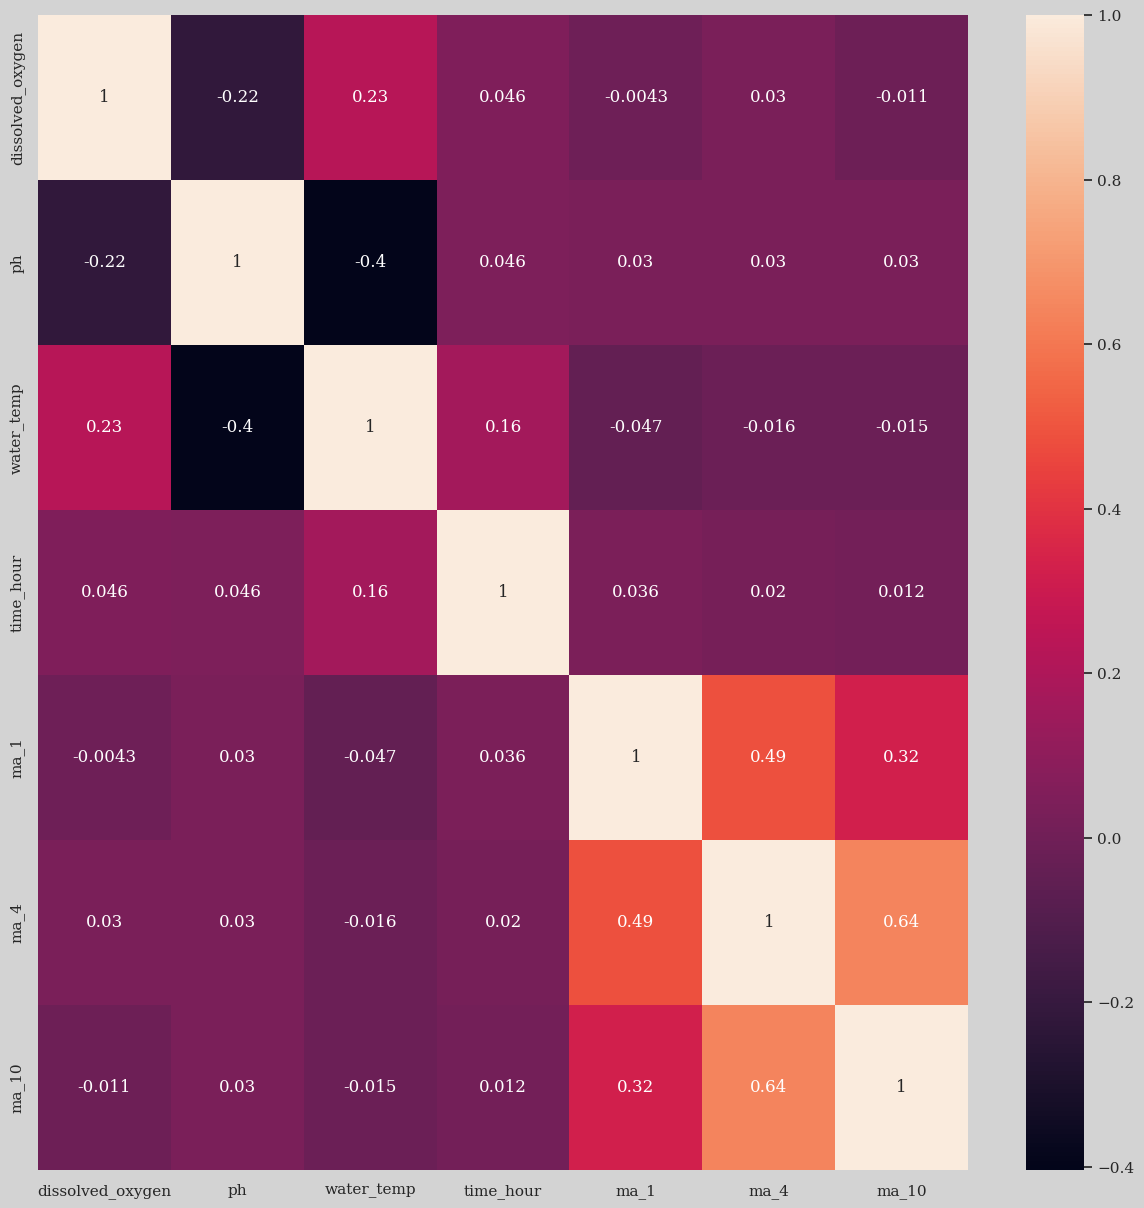

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(new_df_copy.drop(columns=["chl", 'datetime', 'ma_3', 'ma_2', 'ma_5'] + cols_to_drop).corr(), annot=True)

In [33]:
X = new_df_copy.drop(columns=["chl", 'datetime', 'ma_3', 'ma_2', 'ma_5'] + cols_to_drop)
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.264884
time_hour           0.240367
ph                  0.198244
dissolved_oxygen    0.163492
ma_1                0.048101
ma_10               0.043529
ma_4                0.041382
dtype: float64


So we just need to calculate for ma_1, ma_10, ma_4. Although, I think this doesn't contribute much but we'll see.

In [34]:
date_chl = new_df[['datetime', 'chl']].set_index("datetime")
new_df_copy = new_df.copy()

ma_n = [1,4,10]
for n in ma_n:
    new_df_copy[f'ma_{n}'] = new_df_copy['chl'].shift(1).rolling(window=n).mean()
new_df_copy.dropna(inplace=True)

In [35]:
formula = "chl ~ " + " + ".join([col for col in new_df_copy.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df_copy)

regularization_alpha = 0.1

results_lasso = lmlm.fit_regularized(method='elastic_net', L1_wt=1, alpha=regularization_alpha)

print("Lasso Coefficients:")
print(results_lasso.params)

Lasso Coefficients:
Intercept           0.000000
dissolved_oxygen    0.000000
ph                  0.256739
water_temp          0.316942
time_hour           0.103748
ma_1                0.000000
ma_4                0.000000
ma_10               0.000000
dtype: float64


In [36]:
formula = "chl ~ " + " + ".join([col for col in new_df_copy.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df_copy)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     93.31
Date:                Thu, 01 May 2025   Prob (F-statistic):          2.16e-113
Time:                        19:35:05   Log-Likelihood:                -1901.6
No. Observations:                1533   AIC:                             3819.
Df Residuals:                    1525   BIC:                             3862.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0010      0.021     -0.048      0.962      -0.043       0.041
dissolved_oxygen     0.0367      0.022      1.649      0.099      -0.007       0.080
ph                   0.4216      0.024     17.650      0.000       0.375       0.468
water_temp           0.4655      0.024     19.208      0.000       0.418       0.513
time_hour            0.1700      0.022      7.756      0.000       0.127       0.213
ma_1                 0.0207      0.025      0.842      0.400      -0.028       0.069
ma_4                -0.0699      0.061     -1.139      0.255      -0.190       0.050
ma_10                0.0757      0.088      0.862      0.389      -0.097       0.248
==============================================================================
Omnibus:                       20.777   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.573
Skew:                           0.081   Prob(JB):                      0.00113
Kurtosis:                       2.568   Cond. No.                         5.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
date_chl = new_df[['datetime', 'water_temp']].set_index("datetime")
new_df_copy = new_df.copy()

ma_n = range(1,11)
for n in ma_n:
    new_df_copy[f'w_ma_{n}'] = new_df_copy['dissolved_oxygen'].shift(1).rolling(window=n).mean()
new_df_copy.dropna(inplace=True)

In [38]:
X = new_df_copy.drop(columns=["chl", 'datetime'])
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.245414
time_hour           0.229163
ph                  0.178579
dissolved_oxygen    0.140305
w_ma_1              0.027395
w_ma_2              0.024306
w_ma_3              0.020752
w_ma_7              0.020569
w_ma_6              0.019872
w_ma_10             0.019507
w_ma_5              0.019364
w_ma_4              0.019145
w_ma_8              0.018116
w_ma_9              0.017512
dtype: float64


In [39]:
new_df_copy['datetime'].dt.dayofyear

10      223
11      223
12      223
13      223
14      223
       ... 
1538    294
1539    294
1540    294
1541    294
1542    294
Name: datetime, Length: 1533, dtype: int32

In [40]:
new_df_copy = new_df.copy()
new_df_copy['day_of_week'] = new_df_copy['datetime'].dt.day
new_df_copy

,dissolved_oxygen,ph,water_temp,chl,time_hour,datetime,day_of_week
0,-1.794564,0.104626,0.137189,0.354699,-0.670928,2022-08-11 00:01:00,11
1,0.638491,1.245186,-0.598758,-0.112043,-1.410903,2022-08-11 01:01:00,11
2,-0.078968,1.282553,-1.530630,-0.586223,-1.410903,2022-08-11 02:01:00,11
3,0.060495,0.047437,-0.245048,-0.379805,-0.060585,2022-08-11 03:01:00,11
4,0.882023,-2.752801,1.771080,-1.433355,0.610507,2022-08-11 04:01:00,11
...,...,...,...,...,...,...,...
1538,-0.397576,0.221673,-0.775673,-0.400565,1.447552,2022-10-21 10:01:00,21
1539,0.624037,0.056907,1.259177,0.982158,1.100301,2022-10-21 11:01:00,21
1540,-0.323950,-0.055136,0.133104,0.323330,0.351336,2022-10-21 12:01:00,21
1541,-1.811986,-0.100801,-0.650216,-1.420166,-1.907685,2022-10-21 13:01:00,21


In [41]:
X = new_df_copy.drop(columns=["chl", 'datetime'])
y = new_df_copy['chl']
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

water_temp          0.288549
time_hour           0.249449
ph                  0.224944
dissolved_oxygen    0.184739
day_of_week         0.052319
dtype: float64


In [42]:
formula = "chl ~ " + " + ".join([col for col in new_df_copy.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df_copy)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     131.0
Date:                Thu, 01 May 2025   Prob (F-statistic):          8.59e-116
Time:                        19:35:10   Log-Likelihood:                -1915.5
No. Observations:                1543   AIC:                             3843.
Df Residuals:                    1537   BIC:                             3875.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0453      0.049     -0.921      0.357      -0.142       0.051
dissolved_oxygen     0.0348      0.022      1.570      0.117      -0.009       0.078
ph                   0.4230      0.024     17.757      0.000       0.376       0.470
water_temp           0.4604      0.024     19.074      0.000       0.413       0.508
time_hour            0.1747      0.022      8.005      0.000       0.132       0.217
day_of_week          0.0028      0.003      1.023      0.307      -0.003       0.008
==============================================================================
Omnibus:                       20.662   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.734
Skew:                           0.089   Prob(JB):                      0.00104
Kurtosis:                       2.573   Cond. No.                         42.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So that doesn't work.

---

# Final Model

In [43]:
formula = "chl ~ " + " + ".join([col for col in new_df.drop(columns=['datetime']).columns  if col != "chl"])
lmlm = ols(formula, data=new_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     163.5
Date:                Thu, 01 May 2025   Prob (F-statistic):          1.06e-116
Time:                        19:35:10   Log-Likelihood:                -1916.1
No. Observations:                1543   AIC:                             3842.
Df Residuals:                    1538   BIC:                             3869.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -9.021e-17      0.021  -4.22e-15      1.000      -0.042       0.042
dissolved_oxygen     0.0351      0.022      1.583      0.114      -0.008       0.079
ph                   0.4234      0.024     17.774      0.000       0.377       0.470
water_temp           0.4613      0.024     19.126      0.000       0.414       0.509
time_hour            0.1743      0.022      7.990      0.000       0.132       0.217
==============================================================================
Omnibus:                       21.042   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.832
Skew:                           0.085   Prob(JB):                     0.000992
Kurtosis:                       2.569   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

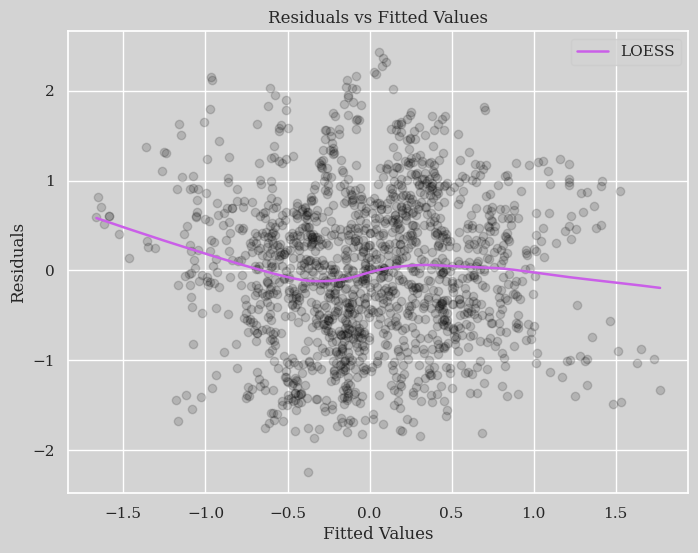

In [44]:
plt.figure(figsize=(8, 6))

sns.regplot(x=results.predict(), 
            y=results.resid, 
            scatter_kws={'alpha':0.15, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(results.resid.to_frame())
standardized_resid = scaler.transform(results.resid.to_frame()).squeeze()
standardized_resid_sorted = np.sort(standardized_resid)

normal_theo = np.sort(np.random.normal(0, 1, len(standardized_resid)));


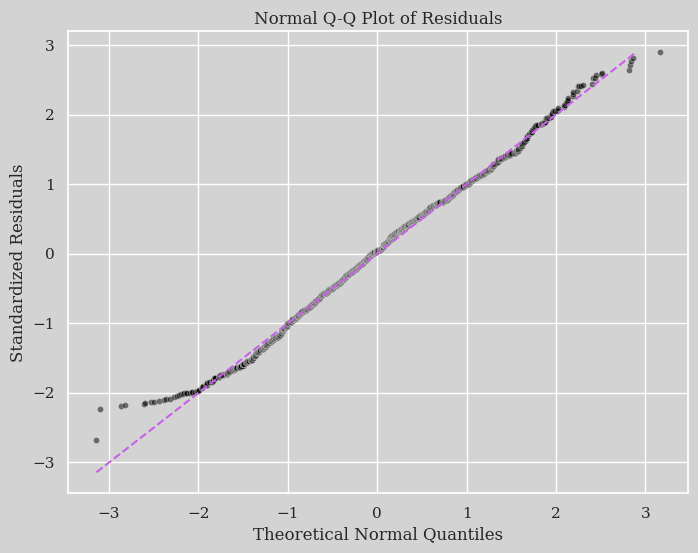

In [46]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))

sns.scatterplot(x=normal_theo,
                y=standardized_resid_sorted,
                color="black",
                ax=ax,
                alpha=0.5,
                s=20)

line_coords = np.linspace(min(normal_theo), max(standardized_resid_sorted))

ax.plot(line_coords, line_coords, color='#ca5fe8', linestyle="--") 


ax.set_title('Normal Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical Normal Quantiles')
ax.set_ylabel('Standardized Residuals');



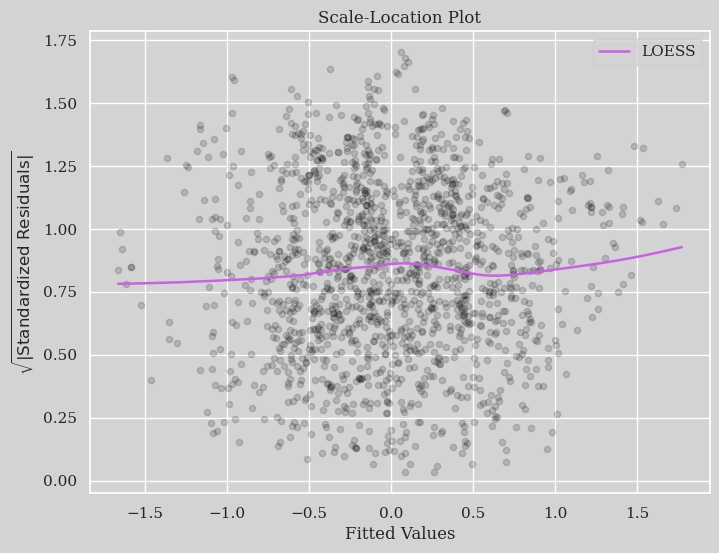

In [47]:

abs_standardized_resid = np.abs(standardized_resid)
sqrt_abs_standardized_resid = np.sqrt(abs_standardized_resid)

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=results.predict(),
            y=sqrt_abs_standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Scale-Location Plot')
ax.set_xlabel('Fitted Values') 
ax.set_ylabel(r'$\sqrt{|\text{Standardized Residuals}|}$')

plt.legend()
plt.show()

In [48]:
influence = results.get_influence()
leverage_values = influence.hat_matrix_diag

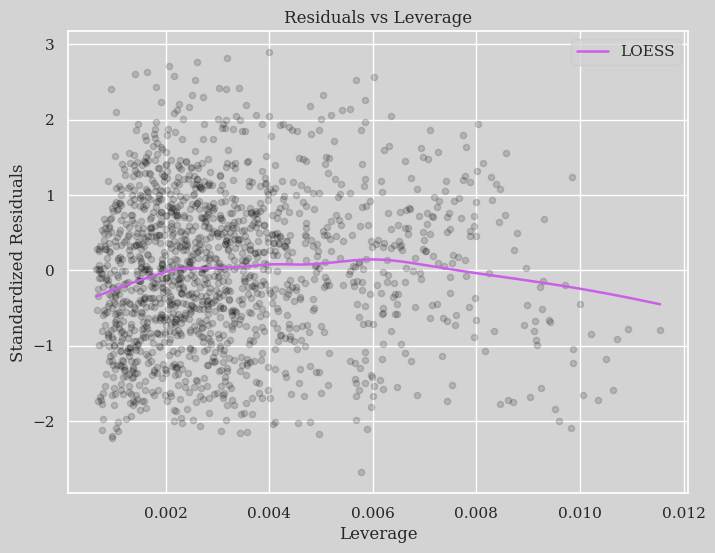

In [49]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=leverage_values,
            y=standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Residuals vs Leverage')
ax.set_ylabel('Standardized Residuals') 
ax.set_xlabel('Leverage')

plt.legend()
plt.show()

### Crooks distance

---

### Evaluation

In [51]:
df_test

,station_name,embayment,longitude,latitude,sample_date,dissolved oxygen,ph,water temp,time,chlorophyll-a
1118,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-28,-1.1248,6.9518,29.1989,10:01:00,1.7545
1653,CCMS_BML,Bolinao,119.9252,16.38712,2022-10-26,-2.0992,6.8951,30.7062,7:01:00,2.2143
1864,CCMS_BML,Bolinao,119.9252,16.38712,2023-10-05,1.0065,0.3600,30.9297,10:01:00,1.8271
941,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-20,0.8576,6.9014,30.2870,23:01:00,6.9333
331,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-25,-1.9552,6.6746,27.5494,3:01:00,1.8634
...,...,...,...,...,...,...,...,...,...,...
567,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-05,-0.2896,7.5629,28.1369,5:01:00,8.0828
720,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-11,-1.5280,6.8636,32.1713,15:01:00,7.9618
1132,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-29,-0.8080,6.9707,29.4892,0:01:00,2.9282
979,CCMS_BML,Bolinao,119.9252,16.38712,2022-09-22,1.5872,6.8888,30.1897,13:01:00,4.2955
